In [189]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import re
import math

Get pre-processed data from `symbol_data_preprocess.py`

In [209]:
with open ('TSCVer1FF_11', 'rb') as fp:
    features_filtered = pickle.load(fp)
with open ('TSCVer1FF_y_11', 'rb') as fp:
    y = pickle.load(fp)

In [210]:
#features_filtered = features_filtered.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#features_filtered = features_filtered.loc[:,~features_filtered.columns.duplicated()].copy()

In [211]:
features_filtered

,rsx__variance_larger_than_standard_deviation,rsx__has_duplicate_max,rsx__has_duplicate_min,rsx__has_duplicate,rsx__sum_values,rsx__abs_energy,rsx__mean_abs_change,rsx__mean_change,rsx__mean_second_derivative_central,rsx__median,...,rsi__permutation_entropy__dimension_5__tau_1,rsi__permutation_entropy__dimension_6__tau_1,rsi__permutation_entropy__dimension_7__tau_1,rsi__query_similarity_count__query_None__threshold_0.0,"rsi__matrix_profile__feature_""min""__threshold_0.98","rsi__matrix_profile__feature_""max""__threshold_0.98","rsi__matrix_profile__feature_""mean""__threshold_0.98","rsi__matrix_profile__feature_""median""__threshold_0.98","rsi__matrix_profile__feature_""25""__threshold_0.98","rsi__matrix_profile__feature_""75""__threshold_0.98"
1,1.0,0.0,0.0,0.0,991.888593,52969.155513,4.341065,0.427746,0.446150,49.791162,...,2.479956,2.615631,2.639057,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
2,1.0,0.0,0.0,0.0,1381.033221,97289.068227,2.182686,0.968468,-0.001349,64.426395,...,2.772589,2.708050,2.639057,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
3,1.0,0.0,0.0,0.0,1040.240024,57087.472117,4.339112,1.951753,0.269045,53.456822,...,2.269639,2.338372,2.403640,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
4,1.0,0.0,0.0,0.0,1300.555896,86541.733691,2.448543,2.199814,0.046984,65.592901,...,2.566599,2.708050,2.639057,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
5,1.0,0.0,0.0,0.0,607.242898,21622.147469,3.462899,0.600655,0.350941,26.674946,...,2.685945,2.708050,2.639057,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,1.0,0.0,0.0,0.0,989.783505,52112.196243,2.843809,1.973807,0.062199,55.963805,...,2.479956,2.615631,2.639057,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
511,1.0,0.0,0.0,0.0,1091.404358,61735.452969,3.708999,2.129916,0.214775,55.617682,...,2.269639,2.338372,2.403640,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
512,1.0,0.0,0.0,0.0,1104.806905,67598.622473,3.706385,2.414166,0.208359,45.083922,...,1.333473,1.599015,1.666102,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484
513,1.0,0.0,0.0,0.0,1096.581024,63177.250450,2.140594,1.672019,0.148767,60.572216,...,2.772589,2.708050,2.639057,0.0,2.581989,4.830459,3.336126,3.412405,3.084173,3.651484


In [212]:
# fix null values
features_filtered = np.log(features_filtered)
features_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
features_filtered.fillna(0, inplace=True)

See how imbalanced the data is

In [213]:
sum(y)/len(y)

0.32490272373540857

In [214]:
X = features_filtered.copy()

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [216]:
X_train

,rsx__variance_larger_than_standard_deviation,rsx__has_duplicate_max,rsx__has_duplicate_min,rsx__has_duplicate,rsx__sum_values,rsx__abs_energy,rsx__mean_abs_change,rsx__mean_change,rsx__mean_second_derivative_central,rsx__median,...,rsi__permutation_entropy__dimension_5__tau_1,rsi__permutation_entropy__dimension_6__tau_1,rsi__permutation_entropy__dimension_7__tau_1,rsi__query_similarity_count__query_None__threshold_0.0,"rsi__matrix_profile__feature_""min""__threshold_0.98","rsi__matrix_profile__feature_""max""__threshold_0.98","rsi__matrix_profile__feature_""mean""__threshold_0.98","rsi__matrix_profile__feature_""median""__threshold_0.98","rsi__matrix_profile__feature_""25""__threshold_0.98","rsi__matrix_profile__feature_""75""__threshold_0.98"
54,0.0,0.0,0.0,0.0,6.988012,11.009965,0.815720,0.000000,-2.699332,3.939037,...,0.955243,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
481,0.0,0.0,0.0,0.0,6.956221,10.988496,0.936695,0.000000,-2.176888,3.981942,...,1.019781,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
12,0.0,0.0,0.0,0.0,6.646959,10.303572,-0.103423,-0.889487,0.000000,3.676935,...,0.797519,0.809130,0.807802,0.0,1.080978,1.457494,1.309034,1.326156,1.252708,1.392522
262,0.0,0.0,0.0,0.0,6.856462,11.042922,1.660731,1.660731,0.000000,3.912023,...,0.988033,0.996229,0.970422,0.0,0.505502,1.672606,1.298109,1.353039,0.919526,1.561253
156,0.0,0.0,0.0,0.0,6.897103,10.822023,0.781989,0.000000,-1.839821,3.870911,...,1.019781,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,0.0,0.0,0.0,0.0,7.106106,11.268611,0.963201,0.000000,-1.758488,4.197372,...,0.942582,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
188,0.0,0.0,0.0,0.0,6.717975,10.495793,0.970462,0.195795,0.000000,3.760575,...,0.921341,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
190,0.0,0.0,0.0,0.0,7.226890,11.498552,1.056421,0.281623,-1.381619,4.108003,...,0.116926,0.329099,0.510487,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
110,0.0,0.0,0.0,0.0,6.803786,10.667416,1.305651,0.737791,-2.046899,3.778860,...,0.908241,0.961505,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134


In [217]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Pipeline
#num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
#                        ('std_scaler', StandardScaler())])              # scale values

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="mean"))])

X_train_prepared = num_pipeline.fit_transform(X_train)
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=X_train.columns)
X_train_prepared_df

,rsx__variance_larger_than_standard_deviation,rsx__has_duplicate_max,rsx__has_duplicate_min,rsx__has_duplicate,rsx__sum_values,rsx__abs_energy,rsx__mean_abs_change,rsx__mean_change,rsx__mean_second_derivative_central,rsx__median,...,rsi__permutation_entropy__dimension_5__tau_1,rsi__permutation_entropy__dimension_6__tau_1,rsi__permutation_entropy__dimension_7__tau_1,rsi__query_similarity_count__query_None__threshold_0.0,"rsi__matrix_profile__feature_""min""__threshold_0.98","rsi__matrix_profile__feature_""max""__threshold_0.98","rsi__matrix_profile__feature_""mean""__threshold_0.98","rsi__matrix_profile__feature_""median""__threshold_0.98","rsi__matrix_profile__feature_""25""__threshold_0.98","rsi__matrix_profile__feature_""75""__threshold_0.98"
0,0.0,0.0,0.0,0.0,6.988012,11.009965,0.815720,0.000000,-2.699332,3.939037,...,0.955243,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
1,0.0,0.0,0.0,0.0,6.956221,10.988496,0.936695,0.000000,-2.176888,3.981942,...,1.019781,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
2,0.0,0.0,0.0,0.0,6.646959,10.303572,-0.103423,-0.889487,0.000000,3.676935,...,0.797519,0.809130,0.807802,0.0,1.080978,1.457494,1.309034,1.326156,1.252708,1.392522
3,0.0,0.0,0.0,0.0,6.856462,11.042922,1.660731,1.660731,0.000000,3.912023,...,0.988033,0.996229,0.970422,0.0,0.505502,1.672606,1.298109,1.353039,0.919526,1.561253
4,0.0,0.0,0.0,0.0,6.897103,10.822023,0.781989,0.000000,-1.839821,3.870911,...,1.019781,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,0.0,0.0,0.0,7.106106,11.268611,0.963201,0.000000,-1.758488,4.197372,...,0.942582,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
407,0.0,0.0,0.0,0.0,6.717975,10.495793,0.970462,0.195795,0.000000,3.760575,...,0.921341,0.996229,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
408,0.0,0.0,0.0,0.0,7.226890,11.498552,1.056421,0.281623,-1.381619,4.108003,...,0.116926,0.329099,0.510487,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134
409,0.0,0.0,0.0,0.0,6.803786,10.667416,1.305651,0.737791,-2.046899,3.778860,...,0.908241,0.961505,0.970422,0.0,0.948560,1.574941,1.204810,1.227417,1.126284,1.295134


Now let's verify that `stratify` worked.

In [218]:
sum(y_train)/len(y_train)

0.3260340632603406

In [219]:
sum(y_test)/len(y_test)

0.32038834951456313

Ratios are good.

In [220]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()

## XGBoost

In [221]:
clf_xgb = XGBClassifier(objective="binary:logistic", seed=42)
clf_xgb.fit(X_train, y_train, 
            verbose=True, 
            early_stopping_rounds=20, 
            eval_metric='auc', 
            eval_set=[(X_test, y_test)])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.63658
[1]	validation_0-auc:0.59286
[2]	validation_0-auc:0.53939
[3]	validation_0-auc:0.53550
[4]	validation_0-auc:0.54394
[5]	validation_0-auc:0.55498
[6]	validation_0-auc:0.55281
[7]	validation_0-auc:0.54935
[8]	validation_0-auc:0.54546
[9]	validation_0-auc:0.52814
[10]	validation_0-auc:0.52554
[11]	validation_0-auc:0.53290
[12]	validation_0-auc:0.53680
[13]	validation_0-auc:0.55195
[14]	validation_0-auc:0.55714
[15]	validation_0-auc:0.55671
[16]	validation_0-auc:0.54502
[17]	validation_0-auc:0.52554
[18]	validation_0-auc:0.52381
[19]	validation_0-auc:0.51862


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

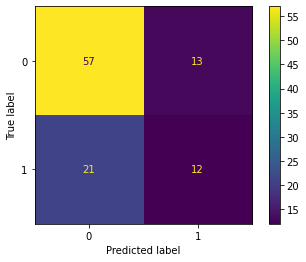

In [222]:
# confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf_xgb, X_test, y_test)

In [54]:
from sklearn.model_selection import GridSearchCV

## ROUND 1
param_grid = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

grid_search_1 = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
                             param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
grid_search_1.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
print(grid_search_1.best_params_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}


In [55]:
## ROUND 2
param_grid = {
    'max_depth': [2,3],
    'learning_rate': [0.1, 0.2, 0.15],
    'gamma': [0.25],
    'reg_lambda': [0.0],
    'scale_pos_weight': [5,6,7]
}

grid_search_2 = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
                             param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
grid_search_2.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
print(grid_search_2.best_params_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 3, 'reg_lambda': 0.0, 'scale_pos_weight': 5}


In [56]:
## ROUND 3
param_grid = {
    'max_depth': [3,4],
    'learning_rate': [0.25, 0.3, 0.35],
    'gamma': [0.25],
    'reg_lambda': [0.0],
    'scale_pos_weight': [5]
}

grid_search_3 = GridSearchCV(estimator=XGBClassifier(objective='binary:logistic', seed=42, subsample=0.9, colsample_bytree=0.5),
                             param_grid=param_grid, scoring='roc_auc', verbose=0, n_jobs=10, cv=3)
grid_search_3.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
print(grid_search_3.best_params_)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'gamma': 0.25, 'learning_rate': 0.25, 'max_depth': 3, 'reg_lambda': 0.0, 'scale_pos_weight': 5}


In [127]:
clf_xgb = XGBClassifier(objective="binary:logistic", seed=43,
                       gamma = 0.25,
                       learning_rate = 0.25,
                       max_depth = 3,
                       reg_lambda = 0.0,
                       scale_pos_weight = 4,
                       subsample = 0.9,
                       colsample_bytree = 0.5)
clf_xgb.fit(X_train, y_train, 
            verbose=True, 
            early_stopping_rounds=30, 
            eval_metric='auc', 
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.63369
[1]	validation_0-auc:0.69920
[2]	validation_0-auc:0.75802
[3]	validation_0-auc:0.76203
[4]	validation_0-auc:0.77807
[5]	validation_0-auc:0.81283
[6]	validation_0-auc:0.79946
[7]	validation_0-auc:0.79679


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[8]	validation_0-auc:0.82888
[9]	validation_0-auc:0.81818
[10]	validation_0-auc:0.83155
[11]	validation_0-auc:0.83155
[12]	validation_0-auc:0.82353
[13]	validation_0-auc:0.83957
[14]	validation_0-auc:0.86364
[15]	validation_0-auc:0.86364
[16]	validation_0-auc:0.86631
[17]	validation_0-auc:0.87166
[18]	validation_0-auc:0.88235
[19]	validation_0-auc:0.87701
[20]	validation_0-auc:0.87968
[21]	validation_0-auc:0.87433
[22]	validation_0-auc:0.86898
[23]	validation_0-auc:0.87701
[24]	validation_0-auc:0.86898
[25]	validation_0-auc:0.87433
[26]	validation_0-auc:0.87166
[27]	validation_0-auc:0.86631
[28]	validation_0-auc:0.87433
[29]	validation_0-auc:0.88503
[30]	validation_0-auc:0.88503
[31]	validation_0-auc:0.88770
[32]	validation_0-auc:0.88770
[33]	validation_0-auc:0.88770
[34]	validation_0-auc:0.88770
[35]	validation_0-auc:0.88770
[36]	validation_0-auc:0.89572
[37]	validation_0-auc:0.89840
[38]	validation_0-auc:0.90107
[39]	validation_0-auc:0.90374
[40]	validation_0-auc:0.90374
[41]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.25, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=43, reg_alpha=0, reg_lambda=0.0,
              scale_pos_weight=4, seed=43, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

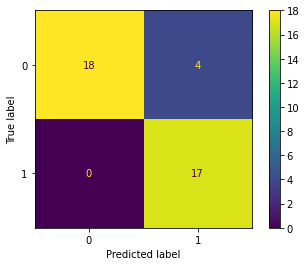

In [128]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf_xgb, X_test, y_test)

In [129]:
# make predictions for test data
y_pred = clf_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.74%


In [84]:
X_train

,"decay__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","decay__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","decay__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","decay__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","decay__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4","slope__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.4","bias__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0","decay__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4",slope__quantile__q_0.1,"ema_25__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.0",...,vwma__absolute_sum_of_changes,"apo__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","mad__fft_coefficient__attr_""abs""__coeff_2","decay__fft_aggregated__aggtype_""centroid""",vhf__partial_autocorrelation__lag_2,"fwma__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","qstick__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","stdev__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.0",pwma__cid_ce__normalize_False,"mom__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0"
93,0.000188,1.835938e-07,0.000188,1.523438e-07,1.835938e-07,0.000000e+00,3.609313e-07,1.523438e-07,0.00000,3.301611e-07,...,7.487438e-03,0.000156,0.000371,0.006327,0.019575,1.904947e-08,2.714681e-09,1.558183e-10,0.002743,0.000000e+00
36,0.000036,5.454545e-09,0.000036,4.132231e-09,5.454545e-09,2.857143e-09,4.829600e-07,4.132231e-09,-0.00020,4.655460e-07,...,9.008334e-03,0.000004,0.000176,0.012767,-0.181067,8.197379e-08,1.706371e-10,8.338159e-10,0.003960,1.000000e-04
122,0.001375,2.234375e-06,0.001500,7.343750e-07,2.472222e-06,2.666667e-06,2.177128e-06,9.166667e-07,-0.00310,2.135635e-06,...,2.876831e-02,0.000418,0.000906,0.024338,-0.311225,4.652154e-07,2.645983e-07,7.460822e-08,0.011243,4.333333e-03
16,0.000308,3.076923e-07,0.000000,2.130178e-07,0.000000e+00,3.593750e-07,1.991595e-06,0.000000e+00,-0.00110,1.713687e-06,...,1.697597e-02,0.000093,0.001454,0.016358,-0.088798,5.610713e-07,3.141274e-08,1.039606e-08,0.008565,8.333333e-04
80,0.000188,1.835938e-07,0.000188,1.523438e-07,1.835938e-07,0.000000e+00,4.225541e-07,1.523438e-07,0.00000,2.788883e-07,...,6.152091e-03,0.000106,0.000921,0.006921,0.133896,2.873629e-08,1.551247e-09,6.558262e-10,0.003302,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0.000078,9.876543e-09,0.000050,3.950617e-09,5.000000e-09,2.000000e-08,1.198880e-06,2.500000e-09,-0.00020,1.129153e-06,...,1.413711e-02,0.000037,0.000180,0.010809,-0.221071,1.248459e-07,1.137396e-09,8.871064e-11,0.005752,1.000000e-04
165,0.005882,5.536332e-04,0.005882,5.536332e-04,5.536332e-04,0.000000e+00,7.499947e-07,5.536332e-04,0.00000,9.269286e-09,...,3.441691e-14,0.003846,0.026215,0.014627,-0.012248,6.029219e-07,4.986150e-06,6.880368e-06,0.008475,0.000000e+00
8,0.001111,2.444444e-06,0.001400,1.654321e-06,2.240000e-06,9.795918e-07,4.153906e-06,2.240000e-06,-0.00200,3.859419e-06,...,3.050970e-02,0.000399,0.004081,0.025459,-0.228901,7.897820e-07,2.199446e-08,4.340437e-10,0.009133,2.000000e-03
149,0.000144,2.246914e-08,0.000120,4.691358e-09,5.600000e-09,6.666667e-09,1.001639e-06,5.600000e-09,-0.00022,9.226093e-07,...,1.945224e-02,0.000013,0.000280,0.016400,-0.275350,2.815479e-07,9.473684e-10,3.836389e-12,0.007247,2.775558e-17


In [85]:
import sklearn.metrics as metrics

probs = clf_xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9171122994652406

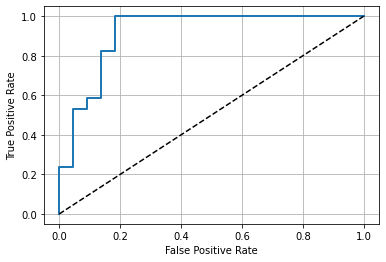

In [86]:
plot_roc_curve(fpr, tpr)

In [87]:
import joblib

## model 5 good
joblib.dump(clf_xgb, 'xgboost_model_new_9.pkl') # to save the model
#forest_loaded = joblib.load("forest_reg.pkl") # to load the model

['xgboost_model_new_9.pkl']

### Feature Importances

In [88]:
def feature_importances(clf, thresh):
    ## most important features
    important_features = []
    for i, x in enumerate(clf.feature_importances_):
        if x >= thresh:
            important_features.append([x, X_train.columns[i]])

    return important_features

feature_importances(clf_xgb, 0.01)

[[0.024951663, 'slope__quantile__q_0.1'],
 [0.015464611,
  'slope__change_quantiles__f_agg_"var"__isabs_True__qh_0.8__ql_0.4'],
 [0.023348792,
  'dpo__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2'],
 [0.033466507, 'dpo__variance'],
 [0.019258175,
  'zlma__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0'],
 [0.03179763,
  'decay__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0'],
 [0.011408146,
  'pwma__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6'],
 [0.017618537, 'kama__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)'],
 [0.033890832,
  'dpo__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2'],
 [0.025215771, 'swma__permutation_entropy__dimension_3__tau_1'],
 [0.055240072,
  'kama__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4'],
 [0.028290855, 'pgo__permutation_entropy__dimension_4__tau_1'],
 [0.044551525, 'dpo__fft_coefficient__attr_"abs"__coeff_5'],
 [0.01212218,
  'quantile__cwt_coefficients__coeff_7__

In [89]:
df_var_imp = pd.DataFrame({"Variable": X_train.columns.values, "Importance": clf_xgb.feature_importances_}) \
                        .sort_values(by="Importance", ascending=False)
df_var_imp[:30]

,Variable,Importance
434,"kama__change_quantiles__f_agg_""mean""__isabs_Tr...",0.055240
1386,"pdist__change_quantiles__f_agg_""mean""__isabs_F...",0.046454
542,"dpo__fft_coefficient__attr_""abs""__coeff_5",0.044552
1199,cti__energy_ratio_by_chunks__num_segments_10__...,0.034997
180,"dpo__change_quantiles__f_agg_""var""__isabs_Fals...",0.033891
125,dpo__variance,0.033467
144,"decay__change_quantiles__f_agg_""var""__isabs_Fa...",0.031798
472,pgo__permutation_entropy__dimension_4__tau_1,0.028291
637,"bias__change_quantiles__f_agg_""mean""__isabs_Tr...",0.026365
615,mfi__approximate_entropy__m_2__r_0.5,0.026024


In [90]:
df_var_imp.loc[df_var_imp['Variable'].str.contains("hurst", case=False)]

,Variable,Importance


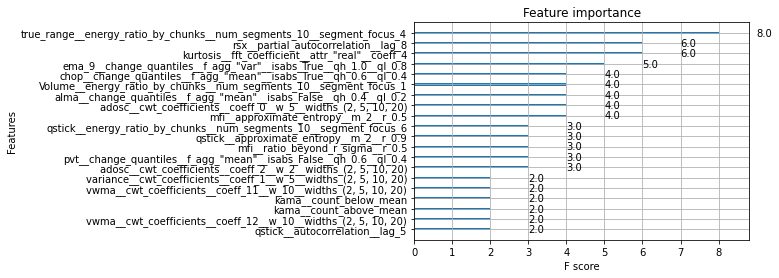

<Figure size 1152x864 with 0 Axes>

In [91]:
xgb.plot_importance(clf_xgb, max_num_features=20)
plt.figure(figsize = (16, 12))
plt.show()

### Learning Curve

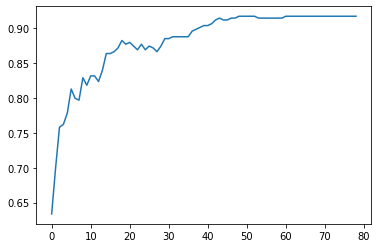

In [92]:
eval_results = clf_xgb.evals_result()
train_auc_tree = eval_results['validation_0']['auc']
plt.plot(train_auc_tree)
plt.show()

### Cross Validation

In [93]:
from xgboost import cv

data_dmatrix = xgb.DMatrix(data=X,label=y)

In [96]:
params = {"objective":"binary:logistic", 'colsample_bytree': 0.5,'learning_rate': 0.25,
                'max_depth':3, 'gamma': 0.25, 'reg_lambda': 0.0, 'scale_pos_weight': 4, "subsample": 0.9}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=40, metrics="auc", as_pandas=True, seed=43)

In [97]:
xgb_cv.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
60,1.0,0.0,0.788622,0.012635
61,1.0,0.0,0.788622,0.012635
62,1.0,0.0,0.788622,0.012635
63,1.0,0.0,0.788622,0.012635
64,1.0,0.0,0.790276,0.010309


In [75]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_scores_auc = cross_val_score(clf_xgb, X, y, cv=fold, scoring="roc_auc")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [76]:
print("ROC AUC Mean Score:", xgb_scores_auc.mean()*100)
print("ROC AUC Standard Dev:", xgb_scores_auc.std()*100, "%")

ROC AUC Mean Score: 82.178011344678
ROC AUC Standard Dev: 6.8736439708583275 %


### $F_1$ Score

In [49]:
y_train_pred_xgb = cross_val_predict(clf_xgb, X_train, y_train, cv=3)
f1_score(y_train, y_train_pred_xgb)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:00:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6140350877192982

## Random Forest

In [50]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_prepared_df, y_train)
y_probas_forest = cross_val_predict(forest_clf, X_train_prepared_df, y_train, cv=3, method="predict_proba")

## CV Scores
forest_scores = cross_val_score(forest_clf, X_train_prepared_df, y_train, cv=3)
print(forest_scores.mean())

0.6797385620915032


In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()

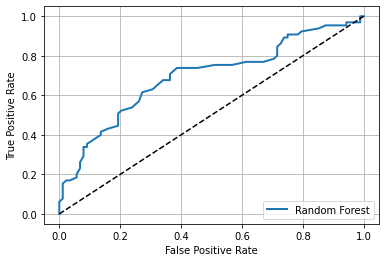

In [52]:
y_scores_forest = y_probas_forest[:,1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [53]:
roc_auc_score(y_train, y_scores_forest)

0.6937062937062938

In [122]:
nums = "9.9 4.7 20.5 1.8 4.7 9.8 20.5 20.2 6.5 3.0"
nl = nums.split(" ")
nl = [float(x) for x in nl]
sorted(nl)

[1.8, 3.0, 4.7, 4.7, 6.5, 9.8, 9.9, 20.2, 20.5, 20.5]

In [64]:
import math

transforms = [-math.log(-math.log(i/11)) for i in range(1,11)]
transforms

[-0.874591382923689,
 -0.5334173533321656,
 -0.26181256163843886,
 -0.011534137037545175,
 0.2376769509413535,
 0.5006512197182452,
 0.7941060117644022,
 1.144278085736196,
 1.6060900454890579,
 2.350618655513294]

In [127]:
transforms = [-math.log(-math.log(i/11)) for i in range(1,11)]

In [129]:
with open ('features_filtered_run8_lower_length', 'rb') as fp:
    features_old = pickle.load(fp)

In [137]:
features_filtered = features_filtered.drop(["Signal"], axis=1)
features_old.equals(features_filtered)

False

In [138]:
features_filtered

,"Close__fft_coefficient__attr_""abs""__coeff_8","Open__fft_coefficient__attr_""abs""__coeff_8","Close__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",Open__time_reversal_asymmetry_statistic__lag_2,"Low__fft_coefficient__attr_""abs""__coeff_8","Close__fft_coefficient__attr_""abs""__coeff_77","High__fft_coefficient__attr_""abs""__coeff_8","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","Close__fft_coefficient__attr_""abs""__coeff_9","Close__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",...,pvt_1h,atr_1h,massi_1h,natr_1h,pdist_1h,rvi_1h,true_range_1h,ui_1h,hurst_exp_1h,hurst_type_1h
1,0.025173,0.019282,0.000017,1.120082e-10,0.018433,0.015561,0.020456,0.000015,0.033452,0.000016,...,9.162954e+05,-0.033633,24.418552,-0.039132,-0.826087,68.566666,-0.692308,1.507879,0.467341,0.0
2,0.027645,0.024743,-0.000128,-1.655072e-09,0.029262,0.063929,0.026581,0.000019,0.016536,0.000018,...,1.120777e+05,0.089935,23.888011,0.089935,0.500000,78.298970,0.071429,0.949848,0.340589,0.0
3,0.097952,0.097848,0.000003,1.489567e-07,0.099890,0.079549,0.105300,0.000061,0.050563,0.000078,...,3.217259e+06,0.043994,27.941065,0.039851,0.195122,60.049549,-0.078431,1.198276,0.349203,0.0
4,0.079002,0.073262,-0.000059,1.805896e-07,0.068182,0.218195,0.081098,0.000067,0.054259,0.000071,...,-7.547686e+06,0.052630,27.839936,0.075122,1.461538,60.431281,1.500000,1.357485,0.431710,0.0
5,0.011948,0.012573,0.000051,2.452577e-08,0.005004,0.038104,0.026740,0.000035,0.066697,0.000035,...,1.498906e+07,0.056029,25.668623,0.083977,-0.157895,64.213403,0.666667,2.765895,0.525222,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.054252,0.053628,0.000356,4.513117e-08,0.038030,0.099610,0.062078,0.000053,0.024424,0.000051,...,8.403342e+08,0.247868,27.651980,0.193832,1.616162,77.181405,2.514286,2.384988,0.208197,0.0
568,0.063140,0.063244,0.000369,4.557885e-09,0.062615,0.051681,0.069387,0.000030,0.030721,0.000037,...,2.467890e+09,0.032179,25.313792,0.016911,1.290780,60.995930,2.080000,1.308526,0.292027,0.0
569,0.069970,0.085123,0.000478,8.217633e-09,0.052260,0.129587,0.093118,0.000104,0.130834,0.000093,...,3.133532e+08,0.097127,27.898363,0.043694,3.447853,46.628815,4.146552,2.307550,0.472064,0.0
570,0.034097,0.075156,0.000434,-3.480053e-08,0.063712,0.081296,0.039088,0.000063,0.063256,0.000059,...,8.767011e+08,0.110751,25.682154,0.041315,1.775000,44.519228,2.798817,7.456411,0.286371,0.0


In [139]:
features_old

,"Close__fft_coefficient__attr_""abs""__coeff_8","Open__fft_coefficient__attr_""abs""__coeff_8","Close__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",Open__time_reversal_asymmetry_statistic__lag_2,"Low__fft_coefficient__attr_""abs""__coeff_8","Close__fft_coefficient__attr_""abs""__coeff_77","High__fft_coefficient__attr_""abs""__coeff_8","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","Close__fft_coefficient__attr_""abs""__coeff_9","Close__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",...,pvt_1h,atr_1h,massi_1h,natr_1h,pdist_1h,rvi_1h,true_range_1h,ui_1h,hurst_exp_1h,hurst_type_1h
1,0.025173,0.019282,0.000017,1.120082e-10,0.018433,0.015561,0.020456,0.000015,0.033452,0.000016,...,1.120777e+05,0.089935,23.888011,0.089935,0.500000,78.298970,0.071429,0.949848,0.340589,0.0
2,0.027645,0.024743,-0.000128,-1.655072e-09,0.029262,0.063929,0.026581,0.000019,0.016536,0.000018,...,3.217259e+06,0.043994,27.941065,0.039851,0.195122,60.049549,-0.078431,1.198276,0.349203,0.0
3,0.097952,0.097848,0.000003,1.489567e-07,0.099890,0.079549,0.105300,0.000061,0.050563,0.000078,...,-7.547686e+06,0.052630,27.839936,0.075122,1.461538,60.431281,1.500000,1.357485,0.431710,0.0
4,0.079002,0.073262,-0.000059,1.805896e-07,0.068182,0.218195,0.081098,0.000067,0.054259,0.000071,...,1.498906e+07,0.056029,25.668623,0.083977,-0.157895,64.213403,0.666667,2.765895,0.525222,1.0
5,0.011948,0.012573,0.000051,2.452577e-08,0.005004,0.038104,0.026740,0.000035,0.066697,0.000035,...,1.996005e+08,-0.043785,25.332876,-0.046282,-0.222222,48.106505,-0.500000,2.459982,0.544127,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0.054252,0.053628,0.000356,4.513117e-08,0.038030,0.099610,0.062078,0.000053,0.024424,0.000051,...,2.467890e+09,0.032179,25.313792,0.016911,1.290780,60.995930,2.080000,1.308526,0.292027,0.0
568,0.063140,0.063244,0.000369,4.557885e-09,0.062615,0.051681,0.069387,0.000030,0.030721,0.000037,...,3.133532e+08,0.097127,27.898363,0.043694,3.447853,46.628815,4.146552,2.307550,0.472064,0.0
569,0.069970,0.085123,0.000478,8.217633e-09,0.052260,0.129587,0.093118,0.000104,0.130834,0.000093,...,8.767011e+08,0.110751,25.682154,0.041315,1.775000,44.519228,2.798817,7.456411,0.286371,0.0
570,0.034097,0.075156,0.000434,-3.480053e-08,0.063712,0.081296,0.039088,0.000063,0.063256,0.000059,...,6.175397e+08,0.012233,26.136251,0.006171,0.215139,68.513471,-0.236842,1.531669,0.514277,1.0


In [147]:
forest_loaded = joblib.load("xgboost_model_new_5.pkl")

In [148]:
forest_loaded

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.25, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=43, reg_alpha=0, reg_lambda=1.0,
              scale_pos_weight=1, seed=43, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)